<h3 align="center">Packages used in the project</h3>

| Package's name | Utility | Link to official documentation|
| :-: | :-: | :-: |
|ipywidgets|Used to generate a GUI|https://ipywidgets.readthedocs.io/en/latest/ |
|serial|Used to communicate using serial communication with different devices|https://pyserial.readthedocs.io/en/latest/pyserial_api.html |
|time|Used to insert some delay between instructions|https://docs.python.org/3/library/time.html |
|chipshouter|Used to control the chipSHOUTER|https://chipshouter.readthedocs.io/en/latest/ |
|chipwhisperer|Used to control the chipwhisperer|https://chipwhisperer.readthedocs.io/en/latest/api.html |
|mysql.connector|Used to interact with the database using Python|https://dev.mysql.com/doc/connector-python/en/ |
|os|Used to interract with the operating system|https://docs.python.org/3/library/os.html |
|numpy|Used to graph the results of the test|https://numpy.org/doc/ |
|matplotlib.pyplot|Used to graph the results of the test|https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html |

In [ ]:
import ipywidgets as widgets # To use widgets and generates a GUI
import serial # To communicate using serial communication with devices
import time # To add some delay between the instructions
from chipshouter import ChipSHOUTER # To use chipSHOUTER's API
import chipwhisperer as cw # To use ChipWhisperer' API
import mysql.connector as mysql # To interact with the database using Python
import os # To use OS commands
import numpy as np # To graph the results
import matplotlib.pyplot as plt # To graph the results

<h3 align="center">Connection with devices</h3>

| Device's name | Utility | Communication type | Baud rate | Link to official documentation|
| :-: | :-: | :-: | :-: | :-: |
|MySQL database|Store datas|non-applicable|non-applicable|https://www.mysql.com/ |
|ChipSHOUTER|EMFI source|3.3V CMOS Serial|115 200|https://www.mouser.ca/datasheet/2/894/NewAE_Technology_Inc._ChipSHOUTER_User_Manual-1858815.pdf |
|Chipwhisperer [<sup>1</sup>](#fn1)|Trigger the chipSHOUTER at a specific moment|USART|[500, 2000000]|https://chipwhisperer.readthedocs.io/en/latest/index.html |
|CNC3018| Test bench |not specified|115 200|http://wiki.sainsmart.com/index.php/101-60-280 |
|Arduino Uno| Used to send values and triggering|UART|9600|https://store.arduino.cc/usa/arduino-uno-rev3|

<span id="fn1"> 1. The connection with the Chipwhisperer is done directly in the sequence.</span>

In [ ]:
"""
Connecting to database.
Uses :
- host name
- username
- password
- database's name
"""

db = mysql.connect(
    host = "localhost",
    user = "root",
    passwd = "92109",
    database = "EMFI")

cursor = db.cursor() # Creation of a cursor to communicate wit DB
    

"""
Open the serial communication with the chipshouter
"""

cs = ChipSHOUTER('COM9') # Establish the serial communication with the serial USB module

time.sleep(2) # Lets time to initialize

cs.mute = True # Mutes the sounds produced by the chipSHOUTER when it's armed, when a pulse is generated or when a fault occurs

"""
Establish the connection with the CNC control board
"""

cnc = serial.Serial('COM11',115200) # Uses serial communication with a 115200 baud rate

time.sleep(2) # Waits for grbl to initialize

cnc.write("$X\r\n".encode()) # Unlocks the CNC machine which is locked initially when HOMING is enable
cnc.write("$H\r\n".encode()) # Sends a HOMING command to the CNC control board

"""
- Open the serial communication with the Arduino
"""

arduino = serial.Serial('COM13',9600) # Uses UART communication with a 9600 baud rate

time.sleep(2) # Waits to initialize

<h3 align="center">Function to read the bit value from Arduino</h3>

Command sent|Returns
:-:|:-:
's'|The FPGA output bit value [<sup>2</sup>](#fn2)

<span id="fn2">2. Returns **'1'** if the pulse had an impact on the implementation logic or on the eFuses values, else 0.

In [ ]:
def read_bit_value():
    """
    - When 's' is sent to the Arduino, the Arduino write the bit value on the serial port.
    - Returns '1' if the pulse had an impact on the implementation logic or the eFuses values, else 0.
    - Look at the Arduino code "Fuses_User.ino" provided in the GIT repo to understand.
    """
    
    arduino.write('s'.encode()) # Send 's' via USB communication
    time.sleep(1) # Waits for the command to complete
    bit_value = arduino.read(1) # Reads the value on the serial port (read one byte)
    
    return bit_value # Returns the bit value

<h3 align="center">Function to program the FPGA</h3>

|Parameters [in]| <center>Utility |
|:-:|:-|
|bitstream_ori|Specifies the bitstream's origin|
|repo|Specifies the repo where to save the test's information|
|config_status|**1** Extracts the CONFIG_SATUS register <br/> **0** Only programs the FPGA|

In [ ]:
def program(bitstream_ori, repo, config_status = 0):
    """
    This function uses a TCL script to program the FPGA.
    The bitstream's path given as input is used.
    
    - If the third argument is '1', a second TCL script
      is used to write the CONFIG_STATUS register values
      in a file.
      
    - Sees the 'config_status_values.tcl' file provided
      in the GIT repo for more details.
    """
    
    cwd = os.getcwd() # Get the current work directory
    
    path = "{" + bitstream_ori + "}"
    
    fich = open("script_Program.tcl", "r") # Open the TCL scrip to program the FPGA
    l = fich.readlines() # Reads the TCL file
    
    # If the configuration file is in the repository, the FPGA cans be program directly
    
    if not os.path.exists(f"{repo}\script_Program.tcl.tmp"):
        f = open(f"{repo}\script_Program.tcl.tmp", "a") # Rewrite the TCL file with the given bitstream's path

        for i in range(6):
            f.write(l[i])

        f.write(f"set_property PROGRAM.FILE {path} [current_hw_device]")
        f.write("\n")
 
        for i in range(3):
            f.write(l[i+7])

        f.close()
    fich.close()

    # Programming the FPGA with the .tmp script contained in newpath
    
    os.system(fr'''cmd /k 'cls & cd / & cd Xilinx\Vivado & cd 2020.2 & cd bin & vivado -mode tcl -source "{repo}\script_Program.tcl.tmp" ' ''')
    
    if config_status == 1: # Extracts the CONFIG_STATUS register if config_status parameter = 1
        """
        Writes the 32 bits config_status values in a file.
        """
        os.system(fr'''cmd /k 'cls & cd / & cd Xilinx\Vivado & cd 2020.2 & cd bin & vivado -mode tcl -source "{os.getcwd()}\config_status_values.tcl" ' ''')

<h3 align="center">Function to readback the bitstream</h3>

|Parameters [in]| <center/>Utility |
|:-:|:-|
|num|Gives a distinction to the extracted bitstream|
|repo|Folder where to save the extracted bitstream|

In [ ]:
def readback(num, repo):
    """
    - Uses the TCL script "script_Readback.tcl" to readback the bitstream.
    - Rename the bitstream according the CNC position and add the new file to the given folder.
    """
    cwd = os.getcwd() # Gets the current work directory (cwd)
    os.system(fr'''cmd /k 'cls & cd / & cd Xilinx\Vivado & cd 2020.2 & cd bin & vivado -mode tcl -source "{cwd}\script_Readback.tcl" ' ''')
    
    os.rename(r"C:\Xilinx\Vivado\2020.2\bin\bitstream_readback.bin", fr'{repo}\bitstream_readback_{num}.bin')

<h3 align="center">Creation of widgets and their associated function (second tab of the GUI)</h3>

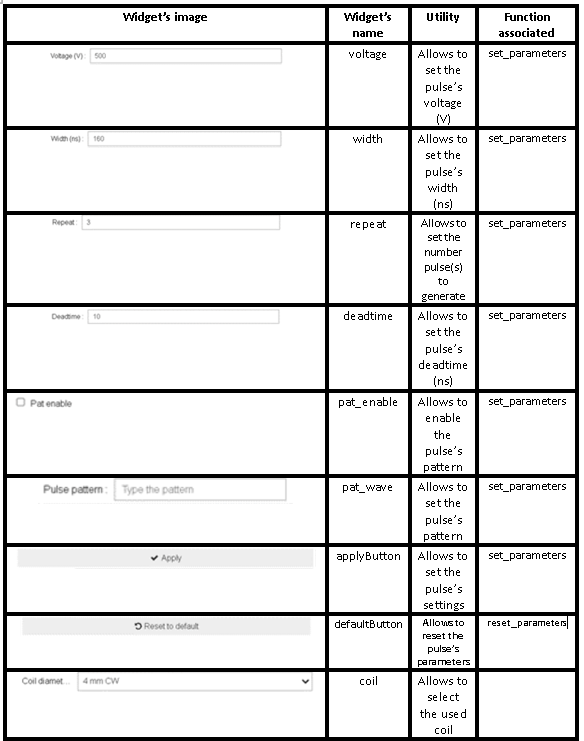

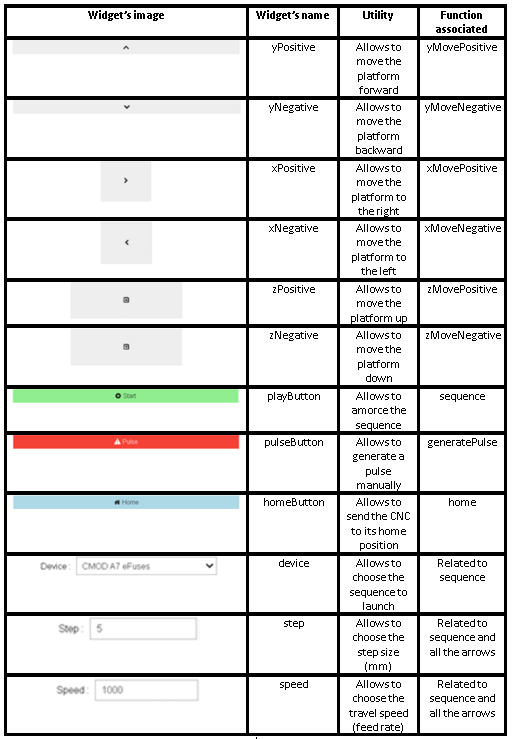

### Creation of widgets

In [ ]:
"""------------------------------------First tab's widgets (Pulse's parameters)----------------------------------------"""
# Creation of the voltage widget
voltage = widgets.BoundedIntText(
    value = 500,
    min = 150,
    max = 500,
    step = 100,
    description = 'Voltage (V) :',
    disabled = False,
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation of the width widget
width = widgets.BoundedIntText(
    value = 160,
    min = 0,
    max = 500,
    step = 100,
    description = 'Width (ns) :',
    disabled = False,
    layout = widgets.Layout(width='auto', height='auto')
)


# Creation of the repeat widget
repeat = widgets.BoundedIntText(
    value = 3,
    min = 1,
    max = 5,
    step = 1,
    description = 'Repeat :',
    disabled = False,
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation of the deadtime widget
deadtime = widgets.BoundedIntText(
    value = 10,
    min = 0,
    max = 50,
    step = 1,
    description = 'Deadtime :',
    disabled = False,
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation of the pat_enable widget
pat_enable = widgets.Checkbox(
    value=False,
    description='Pat enable',
    disabled=False,
    indent=False
)

# Creation of the pat_wave widget
pat_wave = widgets.Text(
    value='',
    placeholder='Type the pattern',
    description='Pulse pattern :',
    disabled=False
)

# Creation applyButton 
applyButton = widgets.Button(
    disabled = False,
    button_style = '',
    description = 'Apply',
    icon = 'check',
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation defaultButton 
defaultButton = widgets.Button(
    disabled = False,
    button_style = '',
    description = 'Reset to default',
    icon = 'rotate-left',
    layout = widgets.Layout(width='auto', height='auto')
)

coil = widgets.Dropdown(
    options=['1 mm CW', '1 mm CCW', '4 mm CW', '4 mm CCW'],
    value='4 mm CW',
    description='Coil diameter :',
    disabled=False,
    layout = widgets.Layout(width='auto', height='auto')
)

"""--------------------------------------------Second tab's widgets (Controller)---------------------------------------"""
# Creation step box
step = widgets.BoundedFloatText(
    value = 5,
    min = 0,
    max = 15,
    step = 1,
    description = 'Step (mm) :',
    disabled = False,
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation speed box
speed = widgets.BoundedFloatText(
    value = 1000,
    min = 10,
    max = 10000,
    step = 100,
    description = 'Speed :',
    disabled = False,
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation device dropdown
sequence = widgets.Dropdown(
    options = ['Fuses User', 'Encryption eFuses', 'Fuses User Reverse'],
    value = 'Fuses User',
    description = 'Sequence :',
    disabled = False,)

# Creation of the play button
playButton = widgets.Button(
    disabled = False,
    button_style = '',
    description = 'Start',
    icon = 'play-circle',
    layout = widgets.Layout(width='auto', height='auto')
)

playButton.style.button_color = 'lightgreen' #set the color to green

# Creation Home button 
homeButton = widgets.Button(
    disabled = False,
    button_style = '',
    description = 'Home',
    icon = 'home',
    layout = widgets.Layout(width='auto', height='auto')
)

homeButton.style.button_color = 'lightblue' #set the color to green

#Creation Pulse button
pulseButton = widgets.Button(
    disabled = False,
    button_style = 'danger',
    description = 'Pulse',
    icon = 'exclamation-triangle',
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation center button 
centerButton = widgets.Button(
    disabled = False,
    button_style = '',
    icon = 'stop-circle-o',
    layout = widgets.Layout(width='auto', height='auto')
)
    
# Creation positive X button 
xPositive = widgets.Button(
    disabled = False,
    button_style = '',
    icon = 'chevron-right',
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation negative X button
xNegative = widgets.Button(
    disabled = False,
    button_style = '',
    icon = 'chevron-left',
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation positive Y button
yPositive = widgets.Button(
    disabled = False,
    button_style = '',
    icon = 'chevron-down',
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation negative Y button
yNegative = widgets.Button(
    disabled = False,
    button_style = '',
    icon = 'chevron-up',
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation positive Z button
zPositive = widgets.Button(
    disabled = False,
    button_style = '',
    icon = 'toggle-up',
    layout = widgets.Layout(width='auto', height='auto')
)

# Creation negative Z button
zNegative = widgets.Button(
    disabled = False,
    button_style = '',
    icon = 'toggle-down',
    layout = widgets.Layout(width='auto', height='auto')
)

### Creation of widget's functions

In [ ]:
"""-----------------------------------First tab's widgets functions (Pulse's parameters)--------------------------------"""
def set_parameters(apply_button):
    """
    Set the voltage between 150 V and 500 V.
    """
    cs.voltage = voltage.value
    
    """
    Set the width of the pulse.
    """
    cs.pulse.width = width.value
    
    """
    Set the number of repetition.
    """
    cs.pulse.repeat = repeat.value
    
    """
    Set the deadtime between pulses.
    """
    cs.pulse.deadtime = deadtime.value
    
    """
    Set the path_enable value.
    If True,the pat wave is used.
    """
    cs.pat_enable = pat_enable.value
    
    """
    Set the pat_wave.
    Each number represents 21 ns.
    1 = HIGH
    0 = LOW
    """
    
    list_char = list(pat_wave.value) # Pulse pattern (char)
    list_int = [] # Pulse pattern (int)
    
    for char in list_char:
        list_int.append(int(char))
    
    cs.pat_wave = list_int
    
def reset_parameters(defaultButton):
    """
    - Reset chipShouter parameters to default.
    - Display values on the GUI.
    """
    cs.reset_config = 1 # Reset parameters to default
    
    voltage.value = 500
    width.value = 160
    repeat.value = 3
    deadtime.value = 10
    pat_enable.value = False
    pat_wave.value = ''

"""---------------------------------------Second tab's widgets functions (Controller)----------------------------------"""
# Creation of the function which causes displacement to home position
def home():
    """
    This function is linked to the home button
    and it moves the platform to its home position.
    """
    cnc.write('$H\r\n'.encode()) # $H is the grbl command for homing
    time.sleep(2) # Lets the time to treat the command
    
# Creation of the function which causes displacement xPos
def xMovePositive(step, speed):
    """
    This function is linked to the BoundedFloatText
    and it moves the platform to the right according
    to the number written in the box.
    
    - step[in] : size of the displacement
    - speed[in] : speed of the displacement
    """
    instruction = 'G91 G1 X%g F%g\r\n' % (step.value, speed.value) # Instruction to send (incremential mode)
    cnc.write(instruction.encode()) # Sends the command to the CNC
    time.sleep(2) # Lets time to treat the command
    
# Creation of the function which causes displacement xNeg
def xMoveNegative(step, speed):
    """
    This function is linked to the BoundedFloatText
    and it moves the platform to the left according
    to the number written in the box.
    
    - step[in] : size of the displacement
    - speed[in] : speed of the displacement
    """
    instruction = 'G91 G1 X-%g F%g\r\n' % (step.value, speed.value) # Instruction to send (incremential mode)
    cnc.write(instruction.encode()) # Sends the command to the CNC
    time.sleep(2) # Lets time to treat the command
    
# Creation of the function which causes displacement yPos
def yMovePositive(step, speed):
    """
    This function is linked to the BoundedFloatText
    and it moves the platform up according
    to the number written in the box.
    
    - step[in] : size of the displacement
    - speed[in] : speed of the displacement
    """
    instruction = 'G91 G1 Y%g F%g\r\n' % (step.value, speed.value) # Instruction to send (incremential mode)
    cnc.write(instruction.encode()) # Sends the command to the CNC
    time.sleep(2) # Lets time to treat the command
    
# Creation of the function which causes displacement yNeg
def yMoveNegative(step, speed):
    """
    This function is linked to the BoundedFloatText
    and it moves the platform down according
    to the number written in the box.
    
    - step[in] : size of the displacement
    - speed[in] : speed of the displacement
    """
    instruction = 'G91 G1 Y-%g F%g\r\n' % (step.value, speed.value) # Instruction to send (incremential mode)
    cnc.write(instruction.encode()) # Sends the command to the CNC
    time.sleep(2) # Lets time to treat the command
    
# Creation of the function which causes displacement zPos
def zMovePositive(step, speed):
    """
    This function is linked to the BoundedFloatText
    and it moves the platform in Z positive according
    to the number written in the box.
    
    - step[in] : size of the displacement
    - speed[in] : speed of the displacement
    """
    instruction = 'G91 G1 Z%g F%g\r\n' % (step.value, speed.value) # Instruction to send (incremential mode)
    cnc.write(instruction.encode()) # Sends the command to the CNC
    time.sleep(2) # Lets time to treat the command
    
#Creation of the function which causes displacement zNeg
def zMoveNegative(step, speed):
    """
    This function is linked to the BoundedFloatText
    and it moves the platform in Z negative according
    to the number written in the box.
    
    - step[in] : size of the displacement
    - speed[in] : speed of the displacement
    """
    instruction = 'G91 G1 Z-%g F%g\r\n' % (step.value, speed.value) # Instruction to send (incremential mode)
    cnc.write(instruction.encode()) # Sends the command to the CNC
    time.sleep(2) # Lets time to treat the command
    
def generatePulse():
    """
    Generate a pulse when the pulseBUtton
    is clicked. It uses pulse's parameters
    written in the widgets :
    
    """
    cs.armed = 1 # arms the chipSHOUTER
    time.sleep(3) # Lets the time to arm
    cs.pulse = 1 # Generates a pulse
    time.sleep(2) # Lets time to pulse
    cs.armed = 0 # disarms the chipSHOUTER
    
def closeSC():
    """
    Close serial communication with devices.
    """
    cs.disconnect() # Close the serial connection(SC) with the ChipShouter
    cnc.close() # Close the serial connection(SC) with the CNC card

### Creation of widget's function (sequence)

<h3 align="center">Sequence's  objective</h3>

| Sequence's name | Purpose |Operation|Database's table|
| :-: | :-: |:-:|:-:|
|Fuses User|Find the eFuses User location on the Artix-7 FPGA|If the pulse had an impact on the eFuses User or on the implementation logic, the value of the PMOD1 on the CMOD A7 bord is set to high and read by the Arduino (bit_value).|fuses_user|
|Encryption eFuses|Find the location of eFuses used for encryption and discover a flaw|A PMOD's output is set to HIGH when the FPGA is programmed. When the FPGA is reprogramming, the PMOD goes to low. This falling edge is detected by the Arduino which triggers the Chiwhisperer. This last, triggers the ChipShouter via an SMA cable during the bitstream programming. Then, the CONFIG_VALUES register is extracted in order to observe events caused by the pulse.|encryption_efuses|
|Fuses User Reverse|Find the eFuses User location on the Artix-7 FPGA|Same operation as the Fuses User sequence but travels the rows back and forth.|fuses_user|

<h3 align="center">Fuses User typical circuit implementation</h3>

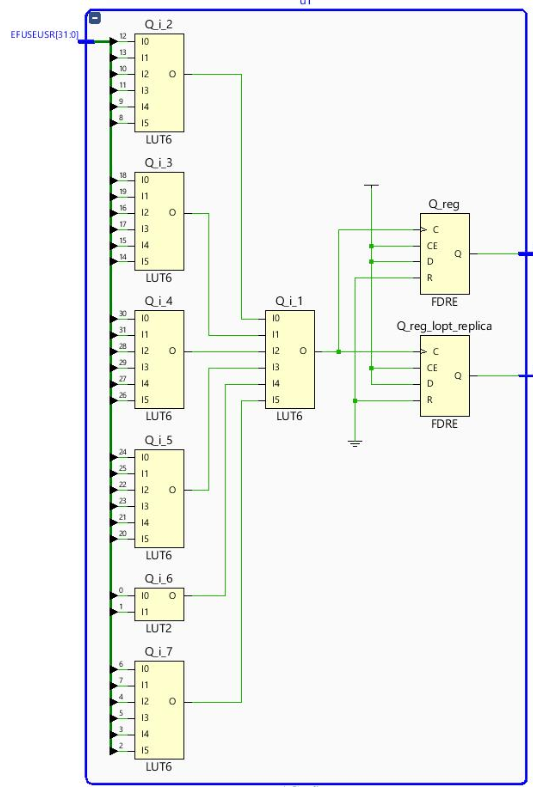

<h3 align="center">Commun extracted data</h3>

|Name|Signification|<center>Important information|
|:-:|:-:|:-|
|test_name|Folder name given as input||
|x_pos|x position of the CNC above the chip|Relative to the lower left corner of the chip[<sup>3</sup>](#fn3)|
|y_pos|y position of the CNC above the chip|Relative to the lower left corner of the chip[<sup>3</sup>](#fn3)|
|z_pos|z position of the CNC above the chip|Position of Z axis written in Candle|
|voltage|pulse's voltage (V)|**Min :** 150 V <br /> **Max :** 500 V
|width|pulse's width (ns)|**Min :** 80 ns <br /> **Max :** 960 ns <br /> **80 ns** is the **maximum** and **15 ns** is the **minimum** for the **1 mm tip**. <br /> **480 ns** is the **maximum** and **24 ns** is the **minimum** for the **4 mm tip**. <br /> Values inferior than 80 ns can be set by using a customed pat_wave|
|num_pulses|number of pulse(s)|**Min :** 1 <br /> **Max :** 10 000 <br /> **2 pulses typical width (minimum) :** 100 ns <br /> **3 pulses typical width (minimum) :** 175 ns|
|deadtime|Time between pulses (ns)|**Min :** 1 ns <br /> **Max :** 1000 ns|
|pat_wave|Personnalized wave pattern|**Max :** 67 characters <br /> Each character is a **21 ns** step. <br /> It is possible to extend the wave further using the pat_append command. <br /> The end the pattern must ends with an inactive value, which will depend on the setting of hwtrig_mode.|
|coil|Used coil's type|**1 mm CCW[<sup>4</sup>](#fn4)/CW[<sup>5</sup>](#fn5):**  Better for precision work, as they generate a narrower field and can be positioned more precisely. <br /> **4 mm CCW/CW :** More powerful and better for manual use and insensitive targets.

<h3 align="center">FPGA'S origin.</h3>

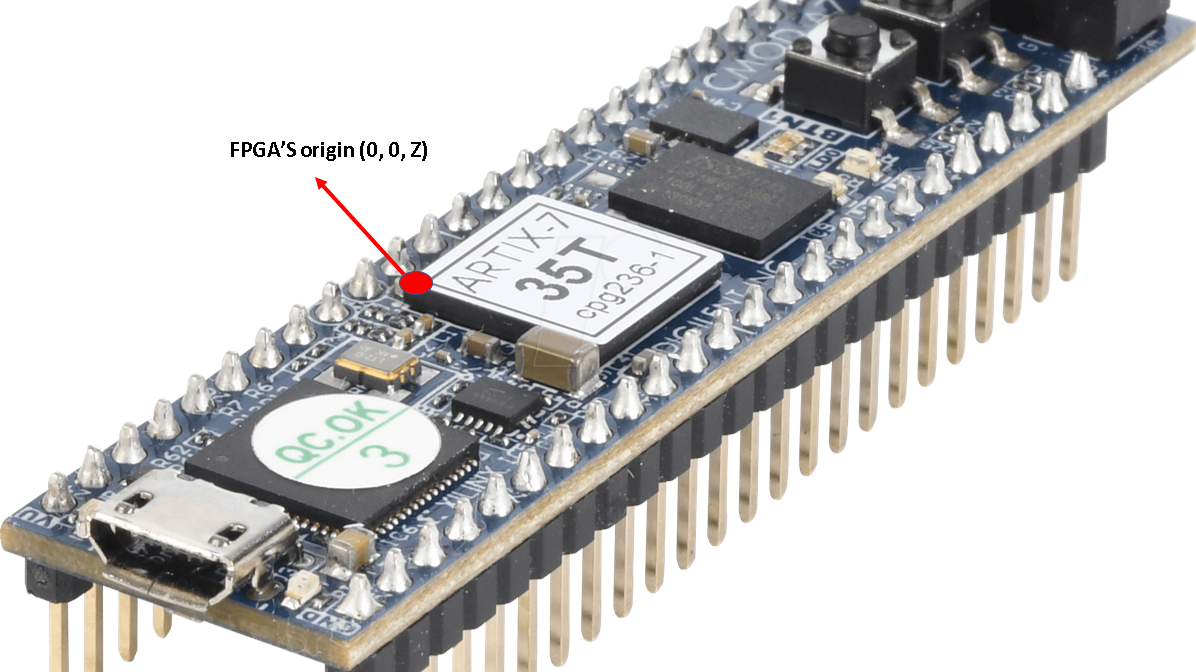

<span id="fn3">3. The used target is not a 35T, but a 15T (10 mm x 10 mm).

<span id="fn4">4. Counter clockwise.

<span id="fn5">5. Clockwise.

<h3 align="center">Encryption eFuses extracted data</h3>

|Bit name|<center>Signification|
|:-:|:-|
|DECRYPTOR_ENABLE|**1** Decryptor's security is defined <br /> **0** Decryptor's security is not defined|
|END_OF_STARTUP(EOS)_STATUS|**1**  The Startup sequence (0~7 phases, EOS is the last phase) has finished<br /> **0** Startup hangs or the device does not enter into Startup stage|
|GHIGH_STATUS|**1** The device has not received the entire configuration data stream <br /> **0** All the bitstream has been received|
|INIT_B|**1** When the initialisation is completed (configuration memory cleared) <br /> **0** Initialization could not be completed or CRC verification failed or a mismatch has been detected between the AES key in the bitstream and the key stored in the device|
|DONE_PIN|**1** Inability to configure the FPGA<br />**0** The FPGA has been configured|
|SECURITY_ERROR|**1** Attempt to write before or after the decryption operation<br />**0** No attempt to write before or after the decryption operation|
|HMAC_ERROR|**1** An error has been detected in the bitstream<br /> **0** The loaded bitstream is the same as the provided one|

<h3 align="center">Parameters used for the Chipwhisperer</h3>

|Parameter's name|Utility|Value|<center>Important information|
|:-:|:-|:-:|:-|
|scope.io.glitch_lp|Whether the low-power MOSFET is enable. The glitch output is an SMA line that is normally connected to the target's power rails. This setting shorts the power rails to ground when the glitch module's output is active (True).|True||
|scope.trigger.triggers|The logical input into the trigger module. Logic combination can be done with max 5 pins to produce a single output value using : <br /> - OR <br /> - AND <br /> - NAND|tio4|Only 1 of the 3 different boolean operations can be used.|
|scope.clock.clkgen_freq|The CLKGEN output in HZ.|12 MHz|**Minimum** clock in practice is 3.2MHz.<br /> **Maximum** is the ChipWhisperer clock frequency wich is  96 MHz|
|scope.glitch.ext_offset|How long the glitch module waits between a trigger and a glitch. After the glich module is triggered, it waits a certain amount of clock cycles before generating glitch pulses. This delay allows to insert a glitch at a specific moment during the target execution to glitch specific instructions.|7 440 000 cycles|**Minimum :** 1 <br /> **Maximum :** 4 294 967 296|
|scope.glitch.repeat|The number of glitch pulses to generate per trigger.|1|**Minimum :** 1 <br /> **Maximum :** 8192|
|scope.glitch.clk_src|The clock signal that the glitch DCM is using as input.|clkgen|The possible values are : <br /> **target :** The HS1 clock from the target device <br /> **clkgen** : The CLKGEN DCM output|
|scope.glitch.trigger_src = "ext_single"|The trigger signal for the glitch pulses.|ext_single|The possible values are : <br /> **continuous :** Constantly trigger glitches <br /> **manual :** Only trigger glitches through API calls/GUI actions <br /> **ext_single :** Use the trigger module. One glitch per scope arm. <br /> **ext_continuous :** Use the trigger module. Many glitches per arm.|
|scope.glitch.output|The type of output produced by the glitch module. Used to combine glitch pulses with the clock.|enable_only|The possible values are : <br /> **clock_only :** Output only the original input clock. <br /> **glitch_only :** Output only the glitch pulses - do not use the clock. <br /> **clock_or :** Output is high if either the clock or glitch are high. <br /> **clock_xor :** Output is high if clock and glitch are different. <br /> **enable_only :** Output is high for glitch.repeat cycles.|

In [ ]:
def sequence(device):
    """
    This is the function where the different sequences are
    defined. Each loop is based on the size of the chip and 
    the number of iterations is defined by the step size.
    
    For the Artix-7 the size of the chip is 10 mm x 10mm. Sequences
    are structured to travel the entire chip's surface. To target specified
    section of the chip, a new sequence must be created. Until now, no
    tool has been developped for this purpose.
    """

    """
    - Lists to show the sensitive spots on the graph for the Fuses User test.
    - The (x,y) coordinates are added to the list when bit_value = 1.
    """
    x_1 = []
    y_1 = []
    
    """
    - Lists to show the sensitive spots on the graph for the Encryption eFuses test.
    - The (x,y) coordinates are added to its associated list when the value of the bit in the CONFIG_
      STATUS register is anormal.
    """
    
    x_DECRYPTOR_ENABLE = [] # DECRYPTOR_ENABLE's value is 0
    y_DECRYPTOR_ENABLE = []
    
    x_EOS = [] # END_OF_STARTUP's value is 0
    y_EOS = []
    
    x_GHIGH = [] # GHIGH's value is 0
    y_GHIGH = []
    
    x_INIT_B = [] # INIT_B's value is 0
    y_INIT_B = []
    
    x_SECURITY_ERROR = [] # SECURITY_ERROR's value is 1
    y_SECURITY_ERROR = []
    
    x_HMAC = [] # HMAC's value is 1
    y_HMAC = []
    
    x_DONE = [] # DONE_PIN's value is 0
    y_DONE = []
    
    """
    FUSES_USER test's query structure for the database.
    Data extracted :
    - test_name --> Folder name given as input
    - device_id --> Always CMOD_A7
    - x_pos --> x position of the CNC above the chip 
    - y_pos --> y position of the CNC above the chip
    - z_pos --> z position of the CNC above the chip
    - bit_value --> bit_value read via serial communication after a pulse
    - voltage --> pulse' voltage
    - width  --> pulse' width
    - num_pulses --> number of pulse(s)
    - deadtime --> Time between pulses
    - pat_wave --> Personalized wave pattern
    - coil --> Used coil's type
    """
    #Query's structure to insert data in the fuses_user table
    
    query_Fuses_User = "INSERT INTO cmod_a7 (test_name, device_id, x_pos, y_pos, z_pos, bit_value, voltage, width, num_pulses, deadtime, pat_wave, coil) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    
    """
    Encrypted bitstream test's query structure for the database.
    Data extracted :
    - test_name --> Folder name given as input
    - x_pos --> x position of the CNC above the chip 
    - y_pos --> y position of the CNC above the chip
    - z_pos --> z position of the CNC above the chip
    - bit_0... bit31 --> [0:31] CONFIG_STATUS bit value
    - voltage --> pulse' voltage
    - width  --> pulse' width
    - num_pulses --> number of pulse(s)
    - deadtime --> Time between pulses
    - pat_wave --> Personalized wave pattern
    - coil --> Used coil's type
    """
    #Query's structure to insert data in the encryption_efuses table
    
    query_Encryption_eFuses = "INSERT INTO cmod_a7_hmac_efuses (test_name, x_pos, y_pos, z_pos, bit_0, bit_1, bit_2, bit_3, bit_4, bit_5, bit_6, bit_7, \
    bit_8, bit_9, bit_10, bit_11, bit_12, bit_13, bit_14, bit_15, bit_16, bit_17, bit_18, bit_19, bit_20, bit_21, bit_22, bit_23, bit_24, \
    bit_25, bit_26, bit_27, bit_28, bit_29, bit_30, bit_31, voltage, width, num_pulses, deadtime, pat_wave, coil) \
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    
                
    """
    Sequence for the Fuses User test
    
    After the pulse, if it had an impact on the FPGA, the value of the PMOD1 on the CMOD A7 bord is set to high
    and read via serial communication (bit_value).
    """
    if sequence.value == 'Fuses User':
        
        """Move to the FPGA origin"""
        
        cnc.write('G90 G1 X-133 Y-94 F500\r\n'.encode()) # Initial coordinates (x,y)
        
        time.sleep(2) # Lets time to treat the command
        
        cnc.write('G90 G1 Z-17.5 F500\r\n'.encode()) # Initial coordinate (z)
        
        time.sleep(20) # Lets the time to reach the initial coordinates before executing an other instruction
        
        """
        Coordinates of the CNC above the chip to write in the database.
        """
        xValue = 0 # X value above the chip --> Sets to 0 at the begining of the test
        yValue = 0 # Y value above the chip --> Set to 0 at the begining of the test
        zValue = -17.5 # Z value --> Stays the same for all the test
        
        cs.reset = 1 # Resets the ChipSHOUTER before starting the sequence
        
        time.sleep(2) # Lets the time to reset
        
        reset_counter = 0 # Counter is initialized to 0. After 50 pulses, the chipShouter is reset manually
        
        for i in range(int(1000//(step.value*100)) + 1): #The range value is defined by the step size. The  loop covers the chip surface.
            
            """
            Instructions to do everytime x_pos = 0 (begining of a row)
            """
            program(origin, newpath) # Program the device with the bitstream given in input
            
            if i > 0: # For all rows except the first one
                
                "Moves the CNC to the next line "
                
                cnc.write('G91 G0 X-10\r\n'.encode()) # Return at the begining of the line
                time.sleep(2) # Lets the time to reach the targeted position
                instruction = 'G91 G0 Y%g\r\n' % (step.value) # CNC goes up (Y) for the step size given in the widget
                cnc.write(instruction.encode()) # Sends the command to the CNC
                time.sleep(2) # Lets the time for the CNC to receive the command
                
                xValue = 0 # Sets the xValue to write in the database to 0 (begining of a line)
                yValue += step.value # Updates the yValue to write in the database
                
            """
            Once the CNC is at the targeted position
            """
           
            cs.armed = 1 # Arms the chipShouter
            
            time.sleep(3) # Lets time to arm
                
            cs.pulse = 1 # Generates a pulse
            
            bit_value = read_bit_value() # Assigns the value of the FPGA PMOD1 to the bit value
                    
            cs.armed = 0 # Disarms the chipShouter

            values = (folder, "CMOD A7", xValue, yValue, zValue, bit_value.decode(), voltage.value, width.value, repeat.value,
                         deadtime.value, pat_wave.value, coil.value) # Values to insert in the cmod_a7 table in the database.

            cursor.execute(query_Fuses_User, values) # Executes the query

            db.commit() # Commits data to database
            
            """
            Adds coordinates where bit_value is 1 to the graph
            """
            if bit_value.decode() == "1":
                x_1.append(xValue)
                y_1.append(yValue)
                
            """
            Update the reset_counter
            """
            reset_counter += 1 # The chipSHOUTER has generated a pulse
                
            for j in range(int(1000//(step.value*100))): #The range value is defined by the step size
                """
                Instructions to do at every x position.
                """
                
                program(origin, newpath) # Program the device with the bitstream provided in input
            
                instruction = 'G91 G0 X%g\r\n' % (step.value) # Moves by the value entered as step size in x (incremental mode)
                cnc.write(instruction.encode()) # Sends the instruction to the CNC control board
                time.sleep(2) # Lets the time to treat the command
                
                """
                Once the CNC is at the targeted position
                """
                
                cs.armed = 1 # Arms the chipSHOUTER
                time.sleep(3) # Lets time to arm
                cs.pulse = 1 # Generates a pulse
                bit_value = read_bit_value() # Assigns the value of the FPGA PMOD1 to the bit value
                cs.armed = 0 # Disarms the chipSHOUTER
                xValue += step.value # Update the X position to write in the database by the step size
                
                values = (folder, "CMOD A7", xValue, yValue, zValue, bit_value.decode(), voltage.value, width.value, repeat.value,
                         deadtime.value, pat_wave.value, coil.value) # Values to insert in the database
                
                cursor.execute(query_Fuses_User, values) # Executes the query
            
                db.commit() # Commits data
                
                """
                Add coordinates where bit_value is 1 to the graph
                """
                
                if bit_value.decode() == '1':
                    x_1.append(xValue)
                    y_1.append(yValue)
                    
                """
                Update the reset_counter
                """
                reset_counter += 1 # The chipSHOUTER has generated a pulse
                
                """
                Reset the chipShouter manually after 50 pulses
                """
                if reset_counter >= 50:
                    cs.reset = 1 # Resets the chipSHOUTER (It keeps the same parameters)
                    time.sleep(2) # Lets the time to reset
                    reset_counter = 0 # Resets the counter's value  
    
    """
    Sequence for the Encryption eFuses test
    
    A PMOD's output is set to HIGH when the FPGA is programmed.
    When the FPGA is reprogramming, the PMOD goes to low. This falling
    edge is detected by the Arduino which triggers the Chiwhisperer. This last,
    triggers the ChipShouter via an SMA cable during the bitstream programming. Then
    the CONFIG_VALUES register is extracted in order to observe events caused by the pulse.
    """
    if sequence.value == 'Encryption eFuses':

        program(origin, newpath, 1) # Initializes a PMOD to HIGH by programming the FPGA
        
        """
        The Chipwhisperer cans only short a device to ground. Then, the ChipSHOUTER must be set
        to trigger on an active-low mode.
        """
        
        cs.hwtrig_term = 0 # Configures the ChipsHOUTER's hardware trigger (SMB connector) as high impedance
        
        cs.hwtrig_mode = 0 # Configures ChipSHOUTER's trigger mode to active-low
        
        scope = cw.scope() # Autoconnects to the Chipwhisperer device
        
        time.sleep(5) # Waits to initialize
        
        
        """
        Whether the low-power MOSFET is enable.

        The glitch output is an SMA line that is normally connected to the target's power rails.
        This setting shorts the power rails to ground when the glitch module's output is active.
        """
        scope.io.glitch_lp = True
        
        """
        The logical input into the trigger module.
        Logic combination can be done with max 5 
        pins to produce a single output value using

        - OR
        - AND
        - NAND
        """
        scope.trigger.triggers = "tio4" # Only one pin value is use as logic combination (Pin IO4 on the CW-Lite board)
        
        """
        The CLKGEN output in HZ.

        - Minimum clock is 3.2 MHz
        """

        scope.clock.clkgen_freq = 12000000 # 12 MHz same as CMOD A7
        
        """
        How long the glitch module waits between a trigger and a glitch.

        After the glich module is triggered, it waits a certain amount of
        clock cycles before generating glitch pulses.

        This delay allows to insert a glitch at a specific moment during the target
        execution to glitch specific instructions.

        - MIN : 0
        - MAX : 2^32
        """
        scope.glitch.ext_offset = 7440000 # FPGA's programmation takes about 1240 ms. We set the upset at the middle (~0.62 s).

        """
        The number of glitch pulses to generate per trigger.

        - MIN : 0
        - MAX : 8192
        """
        scope.glitch.repeat = 1

        """
        The clock signal that the glitch DCM is using as input.

        - target : Use the clock of the target
        - clkgen : The clkgen DCM output
        """
        scope.glitch.clk_src = 'clkgen'

        """
        The trigger signal for the glitch pulses.

        - continuous : Constantly trigger glitches

        - manual : Only trigger glitches through API calls/GUI actions

        - ext_single : Use the trigger module. One glitch per scope arm.

        - ext_continuous : Use the trigger module. Many glitches per arm.
        """
        scope.glitch.trigger_src = "ext_single" # Trigger when the device is armed. Can only trigger as an active-HIGH logic level.

        """
        The type of output produced by the glitch module.

        Used to combine glitch pulses with the clock.

        - clock_only : Output only the original input clock.

        - glitch_only : Output only the glitch pulses - do not use the clock.

        - clock_or : Output is high if either the clock or glitch are high.

        - clock_xor : Output is high if clock and glitch are different.

        - enable_only : Output is high for glitch.repeat cycles.
        """
        scope.glitch.output = "enable_only"
        
        
        """Move to the FPGA origin"""
        
        cnc.write('G90 G1 X-132 Y-94 F500\r\n'.encode()) # Initial coordinates (x, y)
        
        time.sleep(2) #Lets time to treat the command
        
        cnc.write(' G90 G1 Z-16 F500\r\n'.encode()) # Initial coordinates (z)
        
        time.sleep(20) # Lets time to reach the origin of the FPGA
        
        xValue = 0 # X value above the chip --> Sets to 0 at the begining of the test
        yValue = 0 # Y value above the chip --> Sets to 0 at the begining of the test
        zValue = -17.5 # Z value --> Stays the same for all the test 
        
        cs.reset = 1 # Resets the ChipSHOUTER before starting the sequence
        time.sleep(2) # Lets time to reset
        
        reset_counter = 0 # The counter is initializes to 0. After 50 pulses, the chipSHOUTER is reset.
        
        for i in range(int(1000//(step.value*100)) + 1): #The range value is defined by the step size. The  loop cover the chip surface.
            """
            Instructions to do everytime x_pos = 0 (begining of a row)
            """
            if i > 0: # For all rows except the first one
                cnc.write('G91 G0 X-10\r\n'.encode()) # Returns at the begining of the row (x = 0)
                time.sleep(2) # Lets the time to treat the command
                instruction = 'G91 G0 Y%g\r\n' % (step.value) # CNC goes up (Y) for the step size given in the widget
                cnc.write(instruction.encode()) # Sends the instruction to the CNC
                time.sleep(2) # Lets the time to treat the command
                
                xValue = 0 # Resets the X value to write in the database to 0
                yValue += step.value # Updates by the step size written in the widget the Y position to write in the database
            
            cs.clr_armed = 1 # Arms the chipShouter and clears the fault
            
            """
            In manual gitch mode, arming the Chipwhisperer will 
            generate a glitch. In other cases, it arms the 
            ChipWhisperer so it cans generate a glitch.
            """
            scope.arm() # Arms the ChipWhisperer
            
            time.sleep(3) # Lets the time to arm
            
            """
            Programs the FPGA with the bitstream given in input. 
            
            The pulse is generated automatically by an external trigger when the FPGA is programming.
            """
            
            program(origin, newpath, 1) # Programs the device with the given inputs
            
            cs.armed = 0 # Disarms the chipSHOUTER
            
            file = open("config_status_values.out", "r") # Open the file with the extracted CONFIG_STATUS values
            
            file_read = file.readlines() # Reads the file

            config_status_results = list(file_read[0]) # Splits the 32 bits in a list

            first_values = [folder, xValue, yValue, zValue] # Values to insert in the database before the 32 bits config_status register
            
            final_values = [voltage.value, width.value, repeat.value, deadtime.value, pat_wave.value, coil.value] # values to insert in the databse after the 32 bits config_status register
            
            values = first_values + config_status_results[::-1] + final_values # Defines the values as a union of the several lists
            
            cursor.execute(query_Encryption_eFuses, values) # Executes the query

            db.commit() # Commit data
            
            """
            Add the coordinates where an unexpected event has happened to the graph
            """
                
            if config_status_results[30] == '0': # When DECRYPTOR_ENABLE is LOW
                """
                Decryptor security is not set
                """
                x_DECRYPTOR_ENABLE.append(xValue)
                y_DECRYPTOR_ENABLE.append(yValue)
                
                if config_status_results[17] == '1': # DONE_PIN is HIGH and DECRYPTOR_ENABLE is LOW
                    readback(f"{xValue}.{yValue}", newpath) # Readbacks the bitstream
                
            if config_status_results[27] == '0': # When END_OF_STARTUP(EOS)_STATUS is LOW
                """
                Startup hangs or the device does not enter into Startup stage
                """
                x_EOS.append(xValue)
                y_EOS.append(yValue)
                
            if config_status_results[24] == '0': # When GHIGH_STATUS is LOW
                """
                The device does not receive the entire configuration data stream.
                """
                x_GHIGH.append(xValue)
                y_GHIGH.append(yValue)
                
            if config_status_results[20] == '0': # Whwn INIT_B INTERNAL SIGNAL STATUS is LOW
                """
                Internal signal indicating whether initialization has completed and the device is ready to be configured.
                Initialization has not finished.
                """
                x_INIT_B.append(xValue)
                y_INIT_B.append(yValue)
                
            if config_status_results[17] == '0': # When DONE_PIN_STATUS is LOW
                """
                This bit is the value of the internal DONE signal.
                When it is LOW it means the configuration failed.
                """
                x_DONE.append(xValue)
                y_DONE.append(yValue)
                
            if config_status_results[15] == '1': # When SECURITY_ERROR is HIGH
                """
                A FDRI write attempted before or after decrypt operation.
                DEC_ERROR
                """
                x_SECURITY_ERROR.append(xValue)
                y_SECURITY_ERROR.append(yValue)
                
            if config_status_results[4] == '1': # When HMAC_ERROR is HIGH
                """
                HMAC error occurs. There are differences with the original bitstream.
                """
                x_HMAC.append(xValue)
                y_HMAC.append(yValue)    
                
            """
            Update the reset_counter
            """
            reset_counter += 1 # The chipSHOUTER has generated a pulse
                
            for j in range(int(1000//(step.value*100))): #The range value is defined by the step size
                
                """
                Instruction to do at every X position.
                """
                
                instruction = 'G91 G0 X%g\r\n' % (step.value) # Moves the CNC foward in the X axis according to the step value
                cnc.write(instruction.encode()) # Sends the instruction to the CNC control board
                time.sleep(2) # Lets the time to treat the command
                
                cs.clr_armed = 1 # Arms the chipShouter
                
                scope.arm() # Arms the ChipWhisperer
            
                time.sleep(3) # Lets time to arm
                
                """
                Programs the FPGA with the bitstream given in input. 
            
                The pulse is generated automatically by an external trigger when the FPGA is programming.
                """
                
                program(origin, newpath, 1) # Programs the device with the bitstream given in input
                
                cs.armed = 0 # Disarms the ChipSHOUTER
                
                xValue += step.value # Upadates the X position to  write in the database by the step value
                
                file = open("config_status_values.out", "r") # Opens the file with the extracted CONFIG_STATUS values
            
                file_read = file.readlines() # Reads the file

                config_status_results = list(file_read[0]) # Splits the 32 bits in a list

                first_values = [folder, xValue, yValue, zValue] # Values to insert in the database before the 32 bits config_status register

                final_values = [voltage.value, width.value, repeat.value, deadtime.value, pat_wave.value, coil.value] # Values to insert in the database after the 32 bits config_status register

                values = first_values + config_status_results[::-1] + final_values # Defines the values as a union of the several lists

                cursor.execute(query_Encryption_eFuses, values) # Executes the query

                db.commit() # Commits data
                
                """
                Add the coordinates where an unexpected event has happened
                """
                
                if config_status_results[30] == '0': # When DECRYPTOR_ENABLE is LOW
                    """
                    Decryptor security is not set
                    """
                    x_DECRYPTOR_ENABLE.append(xValue)
                    y_DECRYPTOR_ENABLE.append(yValue)
                
                    if config_status_results[17] == '1': # DONE_PIN is HIGH and DECRYPTOR_ENABLE is LOW
                        readback(f"{xValue}.{yValue}", newpath) # Readbacks the bitstream
                
                if config_status_results[27] == '0': # When END_OF_STARTUP(EOS)_STATUS is LOW
                    """
                    Startup hangs or the device does not enter into Startup stage
                    """
                    x_EOS.append(xValue)
                    y_EOS.append(yValue)

                if config_status_results[24] == '0': # When GHIGH_STATUS is LOW
                    """
                    The device does not receive the entire configuration data stream.
                    """
                    x_GHIGH.append(xValue)
                    y_GHIGH.append(yValue)

                if config_status_results[20] == '0': # When INIT_B INTERNAL SIGNAL STATUS is LOW
                    """
                    Internal signal indicating whether initialization has completed 
                    and the device is ready to be configured. Initialization must has not finished.
                    """
                    x_INIT_B.append(xValue)
                    y_INIT_B.append(yValue)

                if config_status_results[17] == '0': # When DONE_PIN_STATUS is LOW
                    """
                    This bit is the value of the internal DONE signal.
                    When the pin is LOW, the configuration has failed.
                    """
                    x_DONE.append(xValue)
                    y_DONE.append(yValue)

                if config_status_results[15] == '1': # When SECURITY_ERROR is HIGH
                    """
                    A FDRI write attempted before or after decrypt operation.
                    DEC_ERROR
                    """
                    x_SECURITY_ERROR.append(xValue)
                    y_SECURITY_ERROR.append(yValue)

                if config_status_results[4] == '1': # When HMAC_ERROR is HIGH
                    """
                    The loaded bitstream is different than the provided one.
                    """
                    x_HMAC.append(xValue)
                    y_HMAC.append(yValue) 
                    
                    """
                    Updates the reset_counter
                    """
                    reset_counter += 1 # The chipSHOUTER has generated a pulse

                """
                Resets the chipSHOUTER manually after 50 pulses
                """
                if reset_counter >= 50:
                    cs.reset = 1 # Resets the chipSHOUTER
                    time.sleep(2) # Lets the time to reset (Keeps its parameters)
                    reset_counter = 0 # Resets the counter to 0
    
    """
    Sequence for the Fuses User Reverse test
    
    After the pulse, if it had an impact on the FPGA, the value of the PMOD1 on the CMOD A7 bord is set to high
    and read via serial communication (bit_value). The rows are traveled back and forth.
    """
    if sequence.value == 'Fuses User Reverse':
        
        """Move to the FPGA origin"""
        
        cnc.write('G90 G1 X-137 Y-93 F500\r\n'.encode()) # Moves the CNC to the chip's origin (x, y)
        
        time.sleep(2) # Lets the time to treat the command
        
        cnc.write(' G90 G1 Z-17 F500\r\n'.encode()) # Moves the CNC to the chip's origin (z) 
        
        time.sleep(20) # Lets the time to the CNC to reach the chip's origin before doing another instruction
        
        cs.reset = 1 # Resets the chipSHOUTER before initiating the sequence
        
        xValue = 0 # X value above the chip --> Sets to 0 at the begining of the test
        yValue = 0 # Y value above the chip --> Sets to 0 at the begining of the test
        zValue = -17 # Z value --> Stays the same for all the test
        
        reset_counter = 0 # The counter is initialized to 0. After 50 pulses, the chipSHOUTER is reset manually
        
        for i in range(int(1000//(step.value*100)) + 1): #The range value is defined by the step size. The  loop cover the chip surface.
            """
            Instructions to execute at every row (x = 0)
            """
            if i > 0: # If it's not the first row
                instruction = 'G91 G0 Y%g\r\n' % (step.value) # CNC goes up (Y) for the step size given in the widget
                cnc.write(instruction.encode()) # Sends to command to the CNC control board
                time.sleep(2) # Lets the time to treat the command
                yValue += step.value # Update the Y position to write in the databse by the step value
                
            for j in range(int(1000//(step.value*100))+1): #The range value is defined by the step size
                """
                Instruction to execute at every X position
                """
                
                program(origin, newpath) # Programs the device with the bitstream given in input
                
                if j > 0: # Moves the CNC foward in the X axis if it's not X = 0
            
                    instruction = 'G91 G0 X%g\r\n' % (step.value) # Moves the CNC foward in the X axis by the step value 
                    cnc.write(instruction.encode()) # Sends the instruction to the CNC control board
                    time.sleep(2) # Lets the time to treat the command
                    xValue += step.value # Updates the X psotion to write in the database by adding the step value to it
                
                """
                Instructions to execute once the CNC is located at the targeted position
                """
                cs.armed = 1 # Arms the chipShouter
                time.sleep(3) # Lets time to arm
                cs.pulse = 1 # Generates a pulse
                
                bit_value = read_bit_value() # Assigns the value of the FPGA PMOD1 to the bit_value
                
                cs.armed = 0 # Disarms the chipSHOUTER
                
                values = (folder, "CMOD A7", xValue, yValue, zValue, bit_value.decode(), voltage.value, width.value, repeat.value,
                        deadtime.value, pat_wave.value, coil.value) # Values to insert in the fuses_user table
                
                cursor.execute(query_Fuses_User, values) # Executes the query
            
                db.commit() # Commits data
                
                """
                Add the coordinates where bit_value is 1 to the graph
                """
                if bit_value.decode() == '1':
                    x_1.append(xValue)
                    y_1.append(yValue)
                    
                """
                Update the reset_counter
                """
                reset_counter += 1 # The chipSHOUTER has generated a pulse
                
                """
                Reset the chipSHOUTER manually after 50 pulses
                """
                if reset_counter >= 50:
                    cs.reset = 1 # Resets the chipSHOUTER
                    time.sleep(2) # Lets the time to reset
                    reset_counter = 0 # Resets the counter's value to 0
             
            for z in range(int(1000//(step.value*100))+1): #The range value is defined by the step size
                
                program(origin, newpath) # Programs the device with the bitstream given in input
                
                if z > 0: # If X position is not x = 10, it moves the CNC backward by the step value
            
                    instruction = 'G91 G0 X-%g\r\n' % (step.value) # Moves the CNC backward by the step value in the X axis
                    cnc.write(instruction.encode()) # Sends the command to the CNC's control board
                    time.sleep(2) # Lets the time to treat the command
                    xValue -= step.value # Uptade the X position to write in the database by the step value
                    
                """
                Instructions to execute once the CNC is located at the targeted position
                """
                
                cs.armed = 1 # Arms the chipSHOUTER
                time.sleep(3) # Lets time to arm
                cs.pulse = 1 # Generates a pulse
                bit_value = read_bit_value() # Assigns the value of the FPGA PMOD to the bit value
                cs.armed = 0 # Disarms the chipSHOUTER
                
                values = (folder, "CMOD A7", xValue, yValue, zValue, bit_value.decode(), voltage.value, width.value, repeat.value,
                        deadtime.value, pat_wave.value, coil.value) # Values to insert in the cmod_a7 table
                
                cursor.execute(query_Fuses_User, values) # Executes the query
            
                db.commit() # Commits data
                
                """
                Add the coordinates where bit_value is 1 to the graph
                """
                if bit_value.decode() == '1':
                    x_1.append(xValue)
                    y_1.append(yValue)
                    
                """
                Update the reset_counter
                """
                reset_counter += 1 # The chipSHOUTER has generated a pulse
                
                """
                Reset the chipSHOUTER manually after 50 pulses
                """
                if reset_counter >= 50:
                    cs.reset = 1 # Resets the chipSHOUTER
                    time.sleep(2) # Lets the time to reset
                    reset_counter = 0 # Resets the counter value to 0
             
    """
    Creation of the graph at the end of the sequence
    """

    fig = plt.figure() # Creates a figure
    ax = fig.add_subplot(111) # Sets the figure's dimensions
    ax.set_facecolor('tab:gray') # Sets the background's color to gray 

    plt.plot(x_1,y_1, linestyle='None')
    plt.xlim(0,10) # X limits are set from 0 to 10 (mm)
    plt.ylim(0,10) # Y limits are set from 0 to 10 (mm) 
    
    """
    Displays the sensible spots on the plot
    """
    plt.scatter(x_1, y_1, s=20, c='r') # Sensible locations in the Fuses User test
    plt.scatter(x_DONE, y_DONE, s=110, c='m', label = 'DONE_PIN') # Sensible locations for DONE_PIN
    plt.scatter(x_DECRYPTOR_ENABLE, y_DECRYPTOR_ENABLE, s=90, c='k', label = 'DECRYPTOR_ENABLE') # Sensible locations for DECRYPTOR_ENABLE
    plt.scatter(x_EOS, y_EOS, s=80, c='y', label = 'EOS') # Sensible locations for EOS 
    plt.scatter(x_GHIGH, y_GHIGH, s=60, c='b', label = 'GHIGH') # Sensible locations for GHIGH
    plt.scatter(x_INIT_B, y_INIT_B, s=40, c='g', label = 'INIT_B') # Sensible locations for INIT_B
    plt.scatter(x_SECURITY_ERROR, y_SECURITY_ERROR, s=20, c='w', label = 'SECURITY') # Sensible locations for SECURITY_ERROR
    
    if device.value == 'Encryption eFuses': 
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left") # Displays a legend if the executed test is Encryption eFuses

    ax.set_aspect('equal', adjustable='box') # Defines the sides as equal

    plt.title(f"Sensible location : {folder}")
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.xticks(np.arange(0, 11, 1.0)) # Graduation step for the x axis is set to 1
    plt.yticks(np.arange(0, 11, 1.0)) #  Graduation step for the Y axis is set to 1

    plt.savefig(newpath) # Saves the graph in the created folder (located in the "Results" folder)
    plt.show() # Displays the graph
    
    """
    Returning to home
    """
    cnc.write('$H\r\n'.encode()) # Sends the CNC to its home position at the end of the sequence

### Associating widgets with their function

In [ ]:
"""------------------------------Creation of outputs for the first tab (Pulse's parameters)-----------------------------"""
output_1 = widgets.Output() # Output for the applyButton
output_2 = widgets.Output() # Output for the defaultButton

"""--------------------------------Creation of outputs for the second tab (Controller)----------------------------------"""
output_1 = widgets.Output() # Output for the applyButton
output0 = widgets.Output() # Output for the homeButton
output1 = widgets.Output() # Output for the xPositive button
output2 = widgets.Output() # Output for the xNegative button
output3 = widgets.Output() # Output for the yPositive button
output4 = widgets.Output() # Output for the yNegative button
output5 = widgets.Output() # Output for the zPositive button
output6 = widgets.Output() # Output for the zNegative button
output7 = widgets.Output() # Output for the generatePulse
output8 = widgets.Output() # Output for the playButton
output9 = widgets.Output() # Output for the centerButton

"""-------------------------Associated functions to the first tab's widgets (Pulse's parameters)------------------------"""
# Associated function to applyButton
def applyButtonClicked(state):
    with output_1:
        set_parameters(applyButton)

applyButton.on_click(applyButtonClicked) # The function is executed when the button is clicked

# Associated function to defaultButton
def defaultButtonClicked(state):
    with output_2:
        reset_parameters(defaultButton)

defaultButton.on_click(defaultButtonClicked) # The function is executed when the button is clicked

"""------------------------------Associated functions to the second tab's widgets (Controller)--------------------------"""
# Associated function to homeButton
def homeButtonClicked(state):
    """
    Uses home as output.
    """
    with output0:
        home()
        
homeButton.on_click(homeButtonClicked) # The function is executed when the button is clicked

# Associated function to xPositive
def xPosButtonClicked(state):
    """
    Uses xMovePositive(step, speed) as output.
    """
    with output1:
        xMovePositive(step, speed)
        
xPositive.on_click(xPosButtonClicked) # The function is executed when the button is clicked

# Associated function to xNegative
def xNegButtonClicked(state):
    """
    Uses xMoveNegative(step, speed) as output.
    """
    with output2:
        xMoveNegative(step, speed)
        
xNegative.on_click(xNegButtonClicked) # The function is executed when the button is clicked

# Associated function to yPositive
def yPosButtonClicked(state):
    """
    Uses yMovePositive(step, speed) as output.
    """
    with output3:
        yMovePositive(step, speed)
        
yPositive.on_click(yPosButtonClicked) # The function is executed when the button is clicked

# Associated function to yNegative
def yNegButtonClicked(state):
    """
    Uses yMoveNegative(step, speed) as output.
    """
    with output4:
        yMoveNegative(step, speed)
        
yNegative.on_click(yNegButtonClicked) # The function is executed when the button is clicked

# Associated function to zPositive
def zPosButtonClicked(state):
    """
    Uses zMovePositive(step, speed) as output.
    """
    with output5:
        zMovePositive(step, speed)
        
zPositive.on_click(zPosButtonClicked) # The function is executed when the button is clicked

# Associated function to zNegative
def zNegButtonClicked(state):
    """
    Uses zMoveNegative(step, speed) as output.
    """
    with output6:
        zMoveNegative(step, speed)
        
zNegative.on_click(zNegButtonClicked) # The function is executed when the button is clicked

# Associated function to pulseButton
def pulseButtonClicked(state):
    """
    Uses generatePulse() as output.
    """
    with output7:
        generatePulse()
        
pulseButton.on_click(pulseButtonClicked) # The function is executed when the button is clicked

# Associated function to playButton
def playButtonClicked(state):
    """
    Uses sequence(device) as output.
    """
    with output8:
        sequence(device)
        
playButton.on_click(playButtonClicked) # The function is executed when the button is clicked

# Associated function to centerButton
def centerButtonClicked(state):
    """
    Uses closeSC() as output.
    """
    with output9:
        closeSC()
        
centerButton.on_click(centerButtonClicked) # The function is executed when the button is clicked

### Grouping widgets

In [ ]:
# Box for the first GUI's tab (Pulse's parameters)

pulseParametersBox = widgets.GridBox(children=[voltage, width, repeat, deadtime, pat_enable, pat_wave, applyButton, defaultButton, coil],
            layout=widgets.Layout(
            width='100%',
            grid_template_rows='auto auto auto auto auto',
            grid_template_columns='50% 50%',
            grid_template_areas='''
            "coil coil"
            "voltage width"
            "repeat deadtime"
            "pat_enable pat_wave"
            "applyButton defaultButton"
            ''')
       )

# Creation of the upper widget

top = widgets.TwoByTwoLayout(top_left=step,
               top_right=zPositive,
               bottom_left=speed,
               bottom_right=zNegative)

# Creation of the lower widget

bot = widgets.AppLayout(header=yNegative,
          left_sidebar=xNegative,
          center=centerButton,
          right_sidebar=xPositive,
          footer=yPositive)

# Box for the second GUI's tab (Controller)

topGridBox = widgets.GridBox(children=[device, playButton, homeButton, pulseButton, top, bot],
            layout=widgets.Layout(
            width='100%',
            grid_template_rows='auto auto',
            grid_template_columns='50% 50%',
            grid_template_areas='''
            "top"
            "device playButton"
            "homeButton pulseButton"
            "bot"
            ''')
       )

<h3 align="center">Essential information (bitstream\ folder)</h3>

<h3 align="center">Useful bitstreams</h3>

|Test|Bitstream's path|
|:-:|:-:|
|Fuses User (No Flip-Flop)|C:\Users\thija8\Desktop\Stage 2021\user_efuse_project\user_efuse_project\user_efuse_project.runs\impl_1\user_efuse.bit|
|Fuses User|C:\Users\thija8\Desktop\Stage 2021\user_efuse_FF\user_efuse_project\user_efuse_project.runs\impl_1\user_efuse.bit|
|Fuses User (different location)|C:\Users\thija8\Desktop\Stage 2021\FPGA\USER_EFUSE_PIO1_2\USER_EFUSE\USER_EFUSE.runs\impl_1\user_efuse.bit|
|Fuses User (No eFuses)|C:\Users\thija8\Desktop\Stage 2021\FPGA\USER_EFUSE_NoFUSE\USER_EFUSE\USER_EFUSE.runs\impl_1\user_efuse.bit|
|Encryption eFuses|C:/Users/thija8/Desktop/Stage 2021/FPGA/PMOD_HIGH/PMOD_HIGH.runs/impl_1/pulse.bit|

In [ ]:
"""----------------------------------------Essential code (bitstream\folder)--------------------------------------------"""

folder = input("Enter the name of the folder that will contain the bitstreams : ") # Defines the name of the folder that will contains the test infomation

cwd = os.getcwd() # Gets the current work directory

newpath = cwd + '\\Results\\' + folder # Defines the path of the folder that will contain the test' information

if not os.path.exists(newpath): # If the folder does not already exist
     os.makedirs(newpath) # Creates the folder that will contain the test' information
else:
    raise Exception("Folder already exists. Chooses another name.")

origin = input("Give the path to the original bitstream in the following format : " \
               + "\n" \
               + r"C:\Users\Bastien\iCloudDrive\Desktop\Laval\Ete 2021\Stage Cyber\Semaine 3\test_FPGA_1\project_1\project_1.runs\impl_1\tutorial.bit"\
               + "\n")

<h3 align="center">Graphical User Interface (GUI) display</h3>

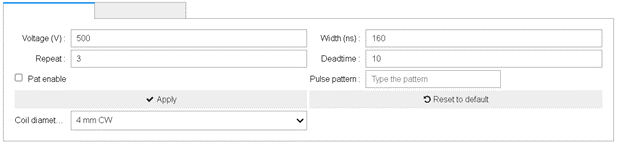

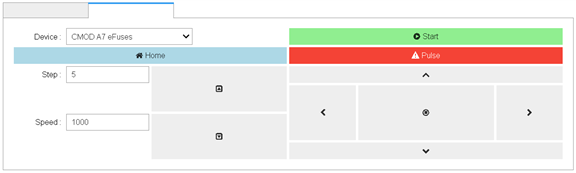

In [ ]:
"""------------------------------------------------Display the GUI--------------------------------------------------------"""
window = widgets.Tab() # Creation of a window
window.children = (pulseParametersBox, topGridBox) # Creation of two tabs

# Display of widgets and outputs

display(window, output0, output1, output2, output3, output4, output5, output6, output7, output8, output9, output_1, output_2)